In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [58]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('bmh')
import symseaman as ss
from symseaman.substitute_dynamic_symbols import lambdify, remove_bis_eq, run
from symseaman.seaman_symbols import *
from vct.bis_system import BisSystem

In [41]:
def data_to_bis(df: pd.DataFrame, lpp_, disp_):
    units = {
        "fy_rudders": "force",
        "fy_rudder": "force",
        "tprop": "force",
    }
    bis_system = BisSystem(lpp=lpp_, volume=disp_, units=units)
    interesting = list(set(bis_system.qd.keys()) & set(df.columns))
    interesting += ["test type", "model_name", "fy_rudders", "fy_rudder", "tprop"]
    interesting = list(set(interesting))
    df_bis = bis_system.df_to_bis(df[interesting])
    return df_bis

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables['ships']

In [4]:
ships

['M5064-02-A']

In [43]:
%reload_kedro
ship='M5064-02-A'
df_VCT = catalog.load(f"{ship}.df_VCT")
df_VCT['tprop'] = df_VCT['thrust']
df_VCT['fy_rudder'] = df_VCT['fy_rudders'] = df_VCT['fy']

[03/08/23 18:21:53] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=571927;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=624710;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/08/23 18:21:53] INFO     Kedro project phd                                                      ]8;id=559332;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=476318;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=276622;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=385964;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=176379;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=639850;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [44]:
df_VCT.head()

,index,Dp,S,V,beta,delta,fx,fy,fz,g,...,p,phi,model_name,test type,eta0,T_tot_net_force,method,tprop,fy_rudder,fy_rudders
0,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,-54129.760606,-1.882611e+06,-8.886267e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.471704e+05,virtual captive test,1.103928e+06,-1.882611e+06,-1.882611e+06
1,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,33405.571316,-9.587846e+05,-7.943515e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.460228e+05,virtual captive test,1.102591e+06,-9.587846e+05,-9.587846e+05
2,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,51311.974521,-5.743306e+05,-7.739233e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.628373e+05,virtual captive test,1.122188e+06,-5.743306e+05,-5.743306e+05
3,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,40982.301461,-4.235769e+05,-7.635107e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.489061e+05,virtual captive test,1.105951e+06,-4.235769e+05,-4.235769e+05
4,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8321.081275,11.317778,0.0,-0.0,122947.475954,-1.827642e+06,-1.530436e+07,9.80665,...,0,0,M5064-02-A,Circle,0.999983,1.780923e+06,virtual captive test,2.075668e+06,-1.827642e+06,-1.827642e+06


In [45]:
df_VCT['test type'].unique()

array(['Circle', 'Circle + Drift', 'Drift angle', 'Rudder angle',
       'Thrust variation', 'self propulsion'], dtype=object)

In [46]:
mask = df_VCT.columns.str.contains('fx')
df_VCT.columns[mask]

Index(['fx'], dtype='object')

In [47]:
df_VCT.columns

Index(['index', 'Dp', 'S', 'V', 'beta', 'delta', 'fx', 'fy', 'fz', 'g', 'lpp',
       'mx', 'my', 'mz', 'r', 'result_file_path', 'rho', 'rn', 'roll', 'u',
       'v', 'PROPLOG', 'rev', 'rev_p5095A', 'rev_p5095B', 'thrust',
       'thrust_p5095A', 'thrust_p5095B', 'torque', 'torque_p5095A',
       'torque_p5095B', 'name', 'path', 'p', 'phi', 'model_name', 'test type',
       'eta0', 'T_tot_net_force', 'method', 'tprop', 'fy_rudder',
       'fy_rudders'],
      dtype='object')

In [48]:
df_bis = data_to_bis(df=df_VCT, lpp_=224.5, disp_=31717.0)

In [49]:
df = df_bis.groupby('test type').get_group('Thrust variation')

<Axes: xlabel='thrust'>

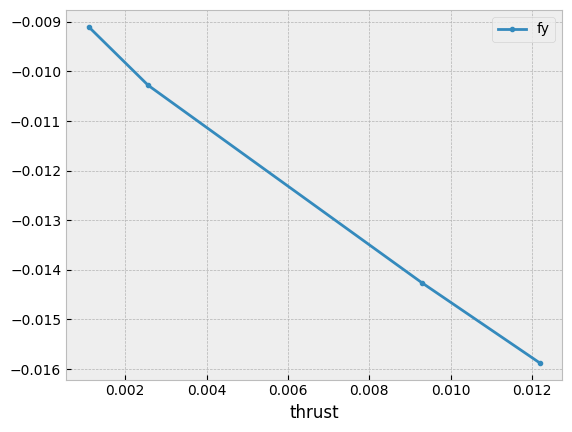

In [50]:
df.sort_values(by='delta').plot(x='thrust', y='fy', style='.-')

In [51]:
remove_bis_eq(ss.equations.rudder.sway.eq_expanded)

Eq(Y_rudder, (s*(delta - k_r*r_w*(-l_cg + xx_rud)/u_w + k_v*v_w/u_w)**2 + 1)*(T_prop*Y_Tdelta*delta*(7.28*u_w + 1.0) + Y_uudelta*u_w**2*(delta - k_r*r_w*(-l_cg + xx_rud)/u_w + k_v*v_w/u_w)))

In [52]:
eq = ss.equations.rudder.sway.eq_expanded.subs([
    (r_w.bis,0),
    (v_w.bis,0),
    
])
remove_bis_eq(eq)

Eq(Y_rudder, (delta**2*s + 1)*(T_prop*Y_Tdelta*delta*(7.28*u_w + 1.0) + Y_uudelta*delta*u_w**2))

In [53]:
eq_thrust_variation = eq.subs([(Y_uudelta,0),])
eq_thrust_variation

Eq(Y''_rudder, delta*T''_prop*Y_Tdelta*(7.28*u''_w + 1.0)*(delta**2*s + 1))

In [54]:
lambda_fy_thrust_variation = lambdify(eq_thrust_variation, convert_to_SI=False)
lambda_fy_thrust_variation

<function _lambdifygenerated(delta, s, tprop, u, ytd)>

In [55]:
variables = [u_w.bis,T_prop.bis,delta,s]
eq = eq_thrust_variation
features = eq.rhs.free_symbols - set(variables)
A_,b_ = sp.linear_eq_to_matrix(eq, features)
A_

Matrix([[-delta*T''_prop*(7.28*u''_w + 1.0)*(delta**2*s + 1)]])

In [56]:
b_

Matrix([[-Y''_rudder]])

In [61]:
lambda_features = lambdify(A_, convert_to_SI=False)
lambda_labels = lambdify(list(b_.free_symbols),b_)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 lambda_features = lambdify(A_, convert_to_SI=False)                                          │
│   2 lambda_labels = lambdify(list(b_.free_symbols),b_)                                           │
│   3                                                                                              │
│                                                                                                  │
│ /home/maa/dev/PHD/venv/lib/python3.10/site-packages/symseaman/substitute_dynamic_symbols.py:150  │
│ in lambdify                                                                                      │
│                                                                                                  │
│   147                                                                                            │
│   148                                                                                            │
│   149 def lambdify(eq: sp.Equality, do_standard_substitutes=True, convert_to_SI=True):           │
│ ❱ 150 │   assert isinstance(                                                                     │
│   151 │   │   eq, sp.Equality                                                                    │
│   152 │   ), "first argument 'eq'  should be an equation (sp.Equality)"                          │
│   153                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError: first argument 'eq'  should be an equation (sp.Equality)

In [60]:
lambda_features

<function _lambdifygenerated(delta, _Dummy_108, s, Dummy_109)>

In [ ]:
data = df
columns =[symbol.name for symbol in features]
X = pd.DataFrame(run(lambda_features(T=data['T'], delta=data['delta'])[0].T, columns=columns, index=data.index)
X['const']=1.0
columns = list(X.columns)

In [138]:
data = df
columns =[symbol.name for symbol in features]
X = pd.DataFrame(lambda_features(T=data['T'], delta=data['delta'])[0].T, columns=columns, index=data.index)
X['const']=1.0
columns = list(X.columns)

In [95]:
X.head()

,Y_td,const
30,89709.958938,1.0
31,208810.157412,1.0
32,756923.184484,1.0
33,992657.419081,1.0


In [141]:
y = -pd.Series(lambda_labels(data['fy']).flatten(), index=data.index)

In [142]:
y.head()

30   -2.831875e+06
31   -3.198708e+06
32   -4.436601e+06
33   -4.938713e+06
dtype: float64

In [143]:
model = sm.OLS(y,X)
regression = model.fit()
regression.summary()

[03/08/23 15:41:45] WARNING  /home/maa/dev/PHD/venv/lib/python3.10/site-packages/statsmodels/stats/ ]8;id=497708;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=287756;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             stattools.py:74: ValueWarning: omni_normtest is not valid with less                   
                             than 8 observations; 4 samples were given.                                            
                               warn("omni_normtest is not valid with less than 8 observations; %i "                
                                                                                                                   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1168.
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           0.000855
Time:                        15:41:45   Log-Likelihood:                -47.612
No. Observations:                   4   AIC:                             99.22
Df Residuals:                       2   BIC:                             98.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y_td          -2.3062      0.067    -34.179      0.001      -2.596      -2.016
const      -2.671e+06   4.28e+04    -62.390      0.000   -2.85e+06   -2.49e+06
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.133
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.406
Skew:                          -0.023   Prob(JB):                        0.816
Kurtosis:                       1.439   Cond. No.                     1.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [144]:
data['OLS'] = regression.predict(X)

In [153]:
mus = {
    'Y_td':regression.params['Y_td'],
    'const':regression.params['const'],
}

stds = {
    'Y_td':regression.bse['Y_td'],
    'const':regression.bse['const'],
    
}

sigma_ = 0.001*data['fy'].abs().max()


In [154]:
basic_model = pm.Model()

sigmas_ = [stds[key] for key in columns]
mus_ = [mus[key] for key in columns]

with basic_model:
    # Priors for unknown model parameters
    parameters = pm.Normal("parameters", mu=mus_, 
                           sigma=sigmas_, 
                           shape=len(mus))
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = pm.math.dot(X, parameters)

    # Likelihood (sampling distribution) of observations
    #fy_obs = pm.Normal("fy_obs", mu=mu, sigma=sigma, observed=data['fy_measure'])
    ν = pm.Uniform("ν", 1, 10)
    Y_obs = pm.StudentT("fy_obs", nu=ν, mu=mu, sigma=sigma, observed=y)
    

In [155]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(draws=1000)

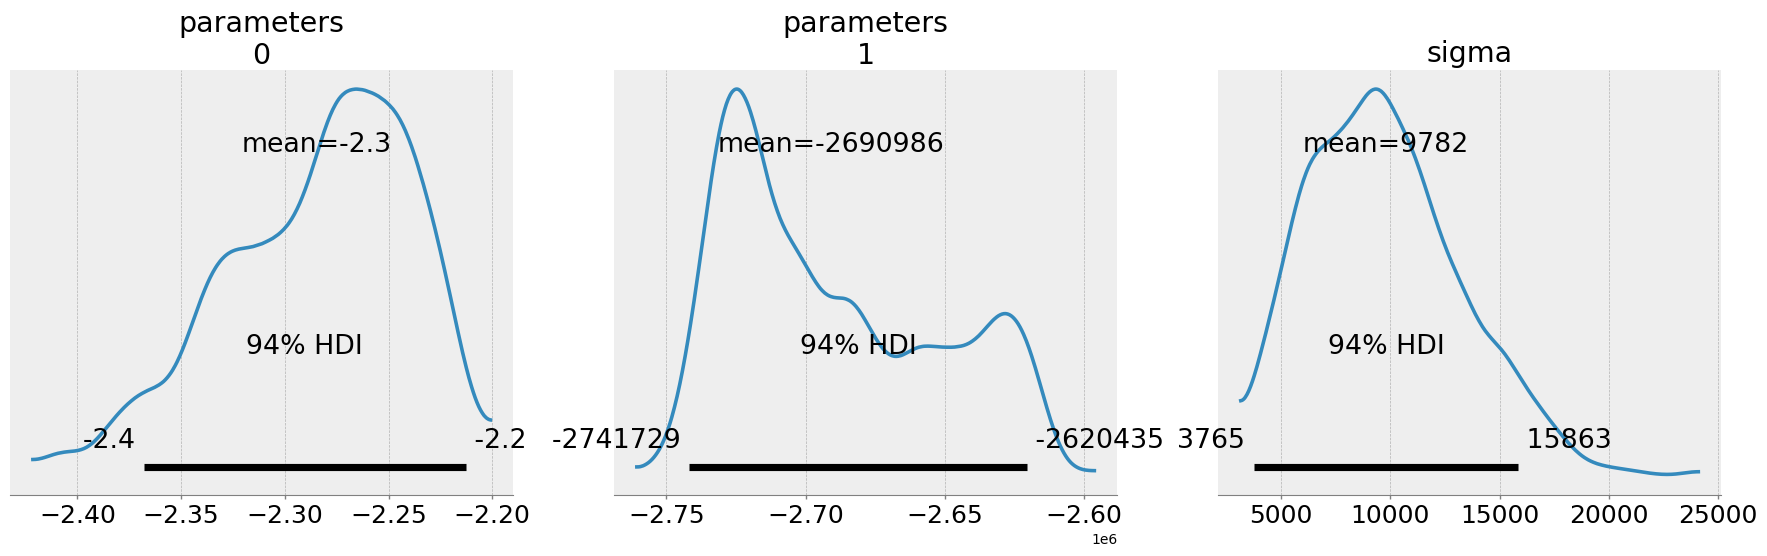

In [156]:
with basic_model:
    az.plot_posterior(trace,
                  var_names=['parameters','sigma'],
                  textsize=18,
                  point_estimate='mean',
                  rope_color='black')

In [157]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[0],-2.284,0.045,-2.368,-2.213,0.003,0.002,332.0,507.0,1.01
parameters[1],-2690986.022,38133.563,-2741729.265,-2620435.017,2213.968,1567.054,351.0,936.0,1.00
sigma,9782.190,3438.106,3765.062,15863.374,130.342,92.205,649.0,581.0,1.00
ν,2.168,1.543,1.001,4.999,0.060,0.045,689.0,511.0,1.00


In [158]:
means = (trace.posterior['parameters'].data[0].mean(axis=0) + trace.posterior['parameters'].data[1].mean(axis=0))/2
means = {key:mean for key,mean in zip(columns,means)}

In [161]:
data['Bayesian'] = means['const'] - lambda_fy_thrust_variation(Y_td=means['Y_td'], delta=data['delta'], T=data['T'])

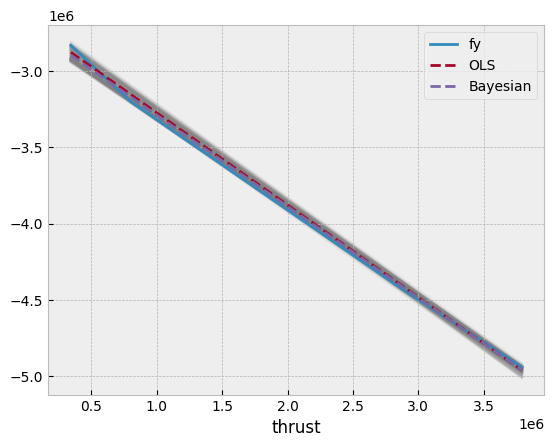

In [164]:
fig,ax=plt.subplots()
data.plot(x='thrust', y='fy', ax=ax)
data.plot(x='thrust', y='OLS', style='--', ax=ax)
data.plot(x='thrust', y='Bayesian', style='--', ax=ax)

for params in trace.posterior['parameters'][0].data[0::10]:
    param = {key:mean for key,mean in zip(columns,params)}
    ax.plot(data['thrust'], param['const'] - lambda_fy_thrust_variation(Y_td=param['Y_td'], delta=data['delta'], T=data['T']), alpha=0.1, color='grey', zorder=-10)